We explore churn distribution and key drivers (tenure, MonthlyCharges, contract).

In [4]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from churn_opt.data import load_telco_csv
from churn_opt.features import add_features

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (9, 5)
sns.set_theme()


In [8]:
df = load_telco_csv("C:/Users/Burakk/Desktop/churn-optimization/data/raw/Telco-Customer-Churn.csv")
df = add_features(df)

# keep consistent with pipeline decision
if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

df.shape, df.head()


((7043, 23),
    gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  Female              0     Yes         No       1           No   
 1    Male              0      No         No      34          Yes   
 2    Male              0      No         No       2          Yes   
 3    Male              0      No         No      45           No   
 4  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity OnlineBackup  \
 0  No phone service             DSL             No          Yes   
 1                No             DSL            Yes           No   
 2                No             DSL            Yes          Yes   
 3  No phone service             DSL            Yes           No   
 4                No     Fiber optic             No           No   
 
   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
 0               No          No          No              No  Month-to-month   
 1 

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   int64  
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   OnlineSecurity       7043 non-null   object 
 9   OnlineBackup         7043 non-null   object 
 10  DeviceProtection     7043 non-null   object 
 11  TechSupport          7043 non-null   object 
 12  StreamingTV          7043 non-null   object 
 13  StreamingMovies      7043 non-null   object 
 14  Contract             7043 non-null   object 
 15  PaperlessBilling     7043 non-null   o

In [12]:
df.isna().mean().sort_values(ascending=False).head(15)


gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
dtype: float64

In [16]:
churn_rate = df["Churn"].mean()
print(churn_rate)


0.2653698707936959


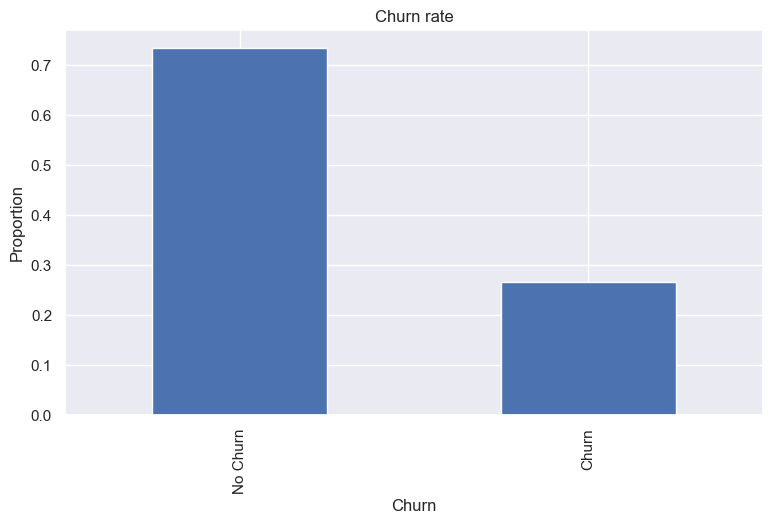

In [18]:
ax = (df["Churn"]
      .value_counts(normalize=True)
      .rename(index={0:"No Churn", 1:"Churn"})
      .plot(kind="bar"))
ax.set_title("Churn rate")
ax.set_ylabel("Proportion")
plt.show()


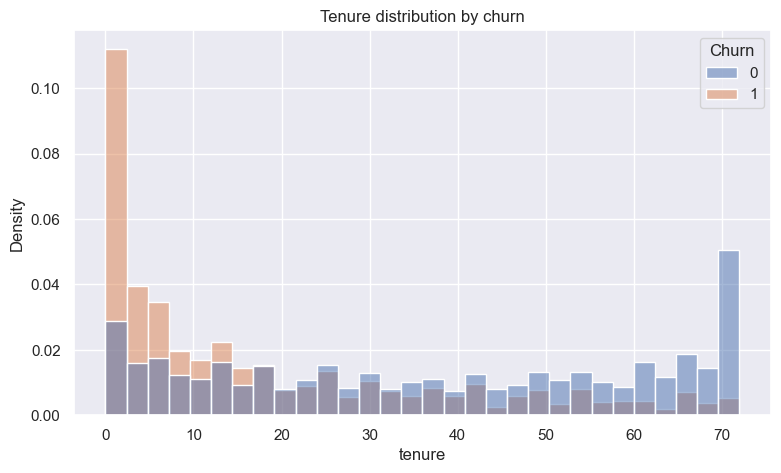

In [20]:
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, stat="density", common_norm=False)
plt.title("Tenure distribution by churn")
plt.show()


C:\Users\Burakk\AppData\Local\Temp\ipykernel_1156\2736426228.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby(bins)["Churn"].mean().reset_index()


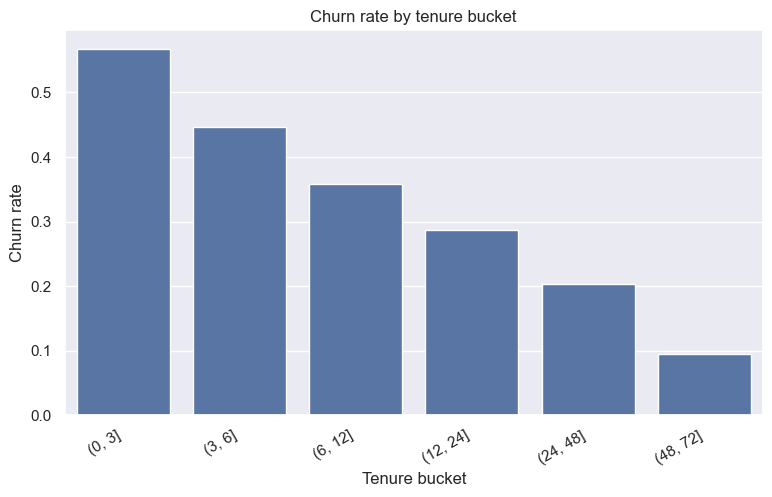

In [22]:
bins = pd.cut(df["tenure"], bins=[0, 3, 6, 12, 24, 48, 72])
tmp = df.groupby(bins)["Churn"].mean().reset_index()
tmp.columns = ["tenure_bin", "churn_rate"]

ax = sns.barplot(data=tmp, x="tenure_bin", y="churn_rate")
ax.set_title("Churn rate by tenure bucket")
ax.set_xlabel("Tenure bucket")
ax.set_ylabel("Churn rate")
plt.xticks(rotation=30, ha="right")
plt.show()


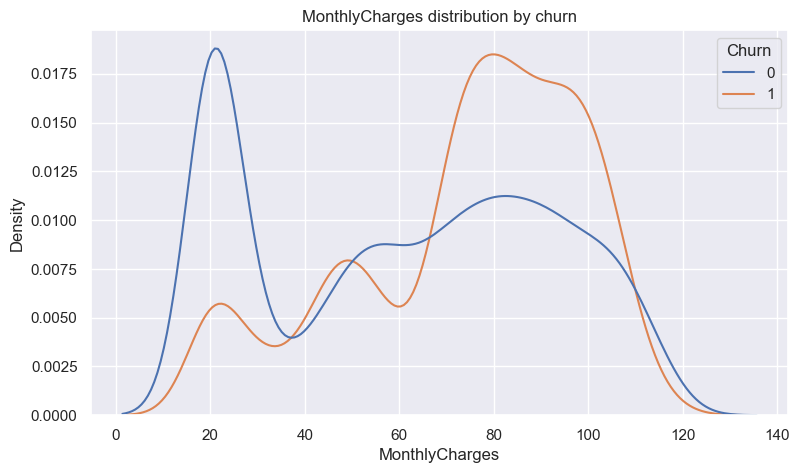

In [24]:
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", common_norm=False)
plt.title("MonthlyCharges distribution by churn")
plt.show()


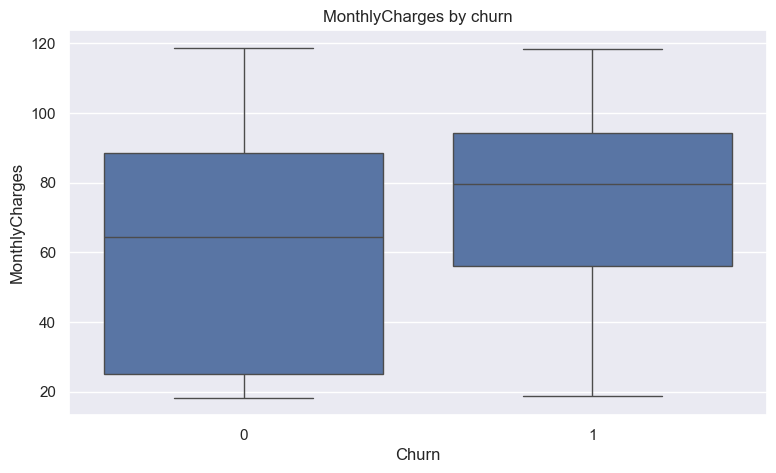

In [26]:
sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
plt.title("MonthlyCharges by churn")
plt.show()


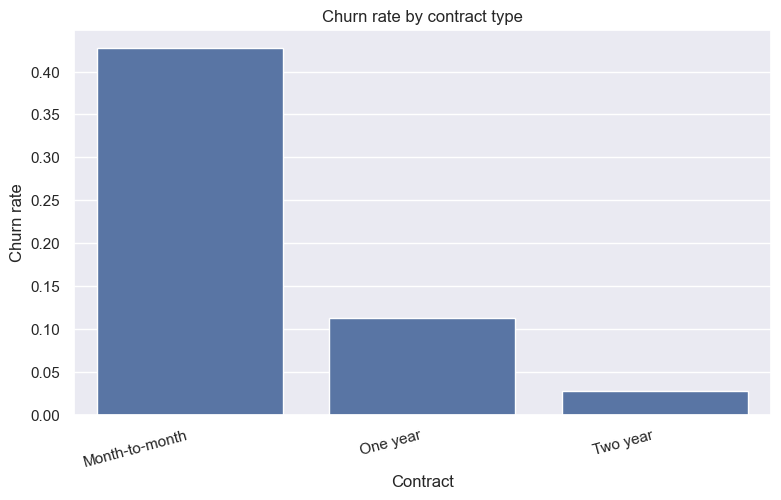

In [28]:
ct = (df.groupby("Contract")["Churn"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={"Churn":"churn_rate"}))

ax = sns.barplot(data=ct, x="Contract", y="churn_rate")
ax.set_title("Churn rate by contract type")
ax.set_ylabel("Churn rate")
plt.xticks(rotation=15, ha="right")
plt.show()


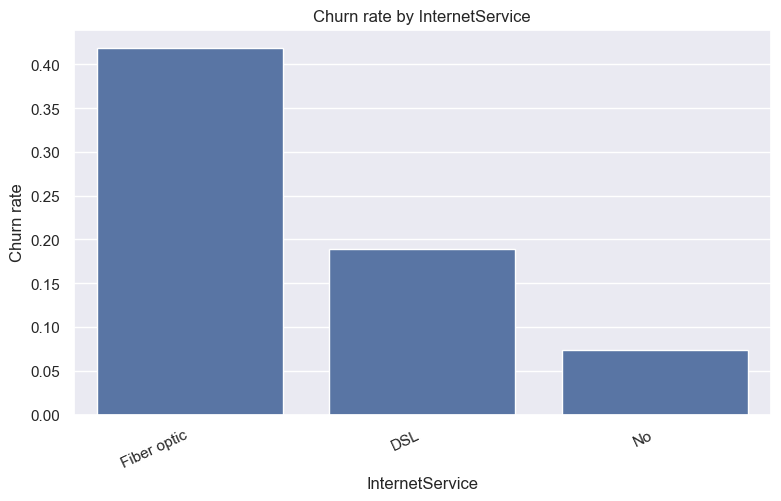

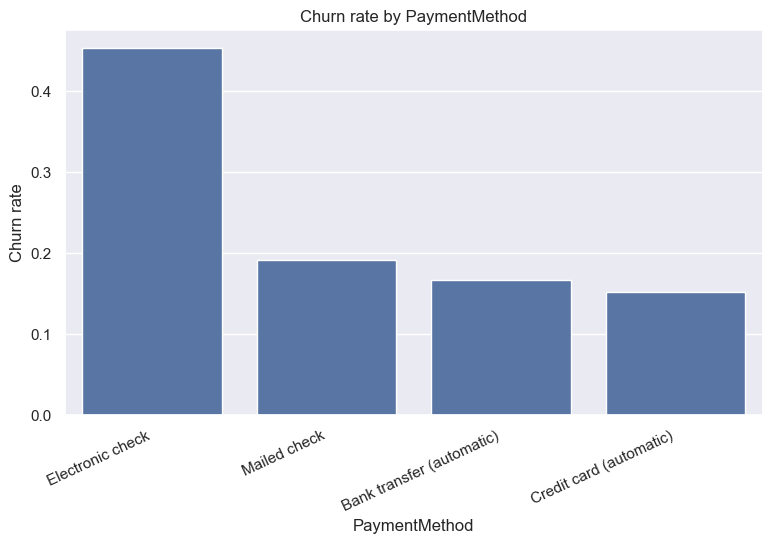

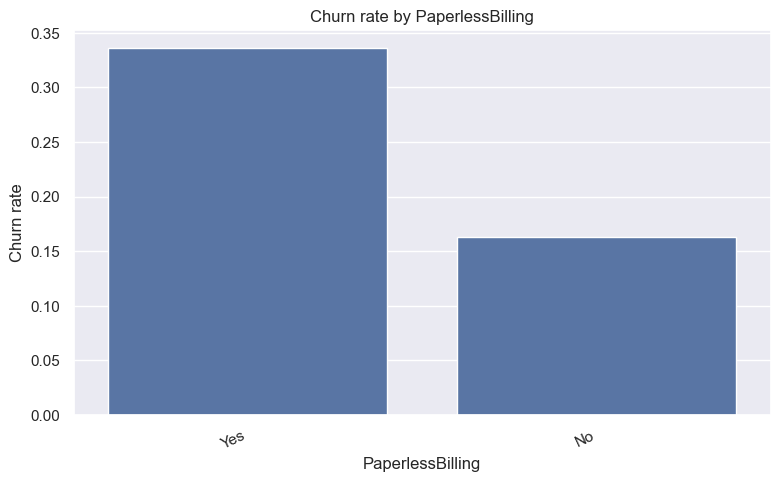

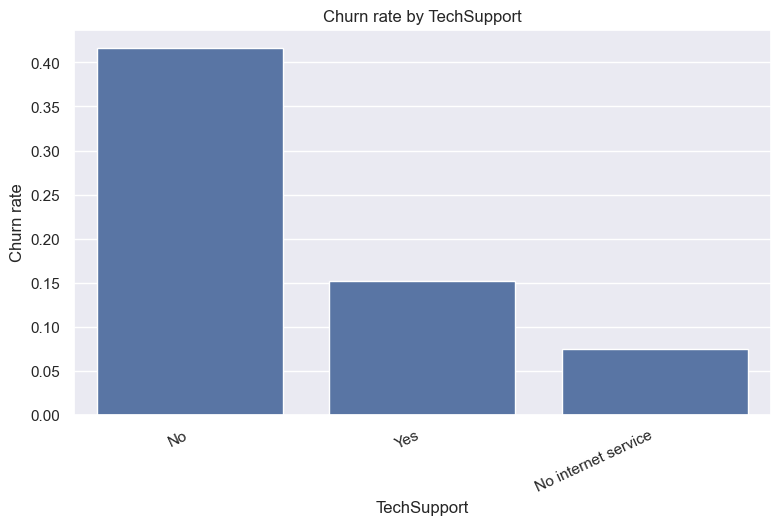

In [30]:
def churn_bar(col):
    tmp = (df.groupby(col)["Churn"].mean()
           .sort_values(ascending=False)
           .reset_index()
           .rename(columns={"Churn":"churn_rate"}))
    ax = sns.barplot(data=tmp, x=col, y="churn_rate")
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate")
    plt.xticks(rotation=25, ha="right")
    plt.show()

for col in ["InternetService", "PaymentMethod", "PaperlessBilling", "TechSupport"]:
    if col in df.columns:
        churn_bar(col)


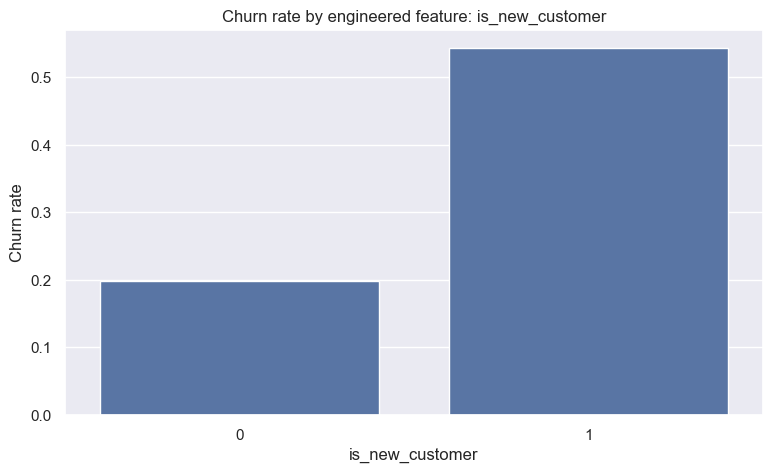

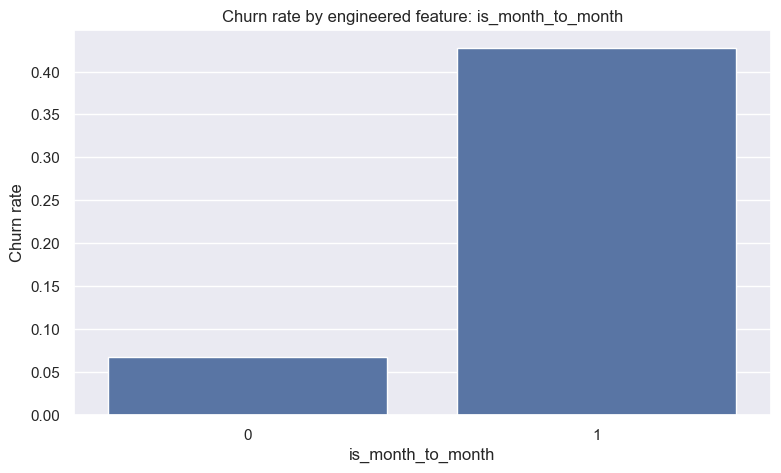

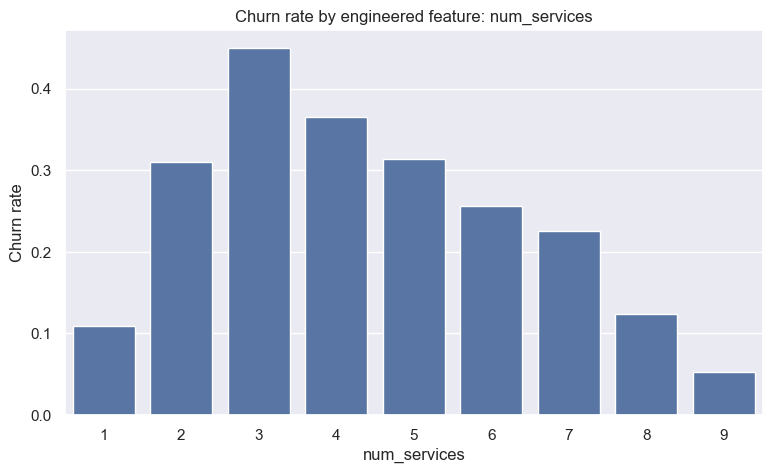

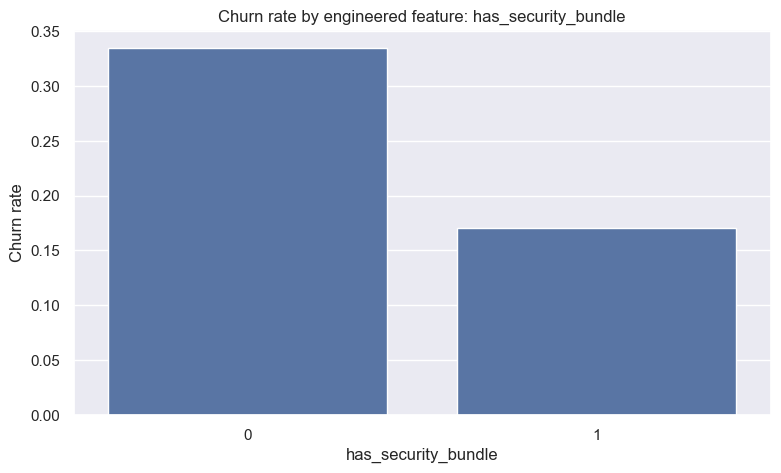

In [32]:
for col in ["is_new_customer", "is_month_to_month", "num_services", "has_security_bundle"]:
    if col in df.columns:
        tmp = df.groupby(col)["Churn"].mean().reset_index().rename(columns={"Churn":"churn_rate"})
        ax = sns.barplot(data=tmp, x=col, y="churn_rate")
        ax.set_title(f"Churn rate by engineered feature: {col}")
        ax.set_ylabel("Churn rate")
        plt.show()


## Conclusion : 
- Churn is higher for month-to-month contracts

- New customers churn more

- Higher monthly charges correlate with higher churn

- Security/support services reduce churn

- Churn is imbalanced 